In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from tqdm import tqdm
tqdm.pandas()


def create_user_data(n, len_sequence):
    ##THIS JUST CREATE A SAMPLE RANDOM DATAFRAME for one user
    # n is the user_id
    # the awards are a random sequence of 0s and 1s (each has probability 0.5) with length len_sequence
    user_id = [n]*len_sequence
    awards = np.random.randint(2, size=len_sequence) #this will just create a random sequence of 0s and 1s
    times = range(len_sequence) #I assume that people post at every timestamp
    return pd.DataFrame(list(zip(user_id, awards, times)),columns = ["author","awarded","created_utc"])

    

def create_random_df(N_Users=1000, len_sequence=1000):
    ### JUST CREATE A  DF with many users
    list_ = [create_user_data(n, len_sequence) for n in range(0,N_Users)]
    df_post = pd.concat(list_)
    return df_post.reset_index(drop=True)

    
def compute_prob_mean_lasse(df_post):
    df_prob=pd.DataFrame()

    # sample 500 awarded users
    for author in tqdm(df_post[df_post['awarded']!=0].author.sample(500).values):
        # compute the commutative sequence with "cumsum"
        sequence=df_post[df_post['author']==author].sort_values(by='created_utc').awarded.cumsum().values
        for k in range(0, max(sequence)):
            occur=np.count_nonzero(sequence == k)
            if k == 0:
                occur = occur + 1
            df_prob.loc[author,k] = 1/(occur)   

    # compute mean
    df_prob_mean=df_prob.mean(axis=0, skipna=True)
    return df_prob_mean



In [2]:
df_post = create_random_df()
print(df_post.head())

   author  awarded  created_utc
0       0        0            0
1       0        0            1
2       0        1            2
3       0        1            3
4       0        1            4


  0%|                                                      | 0/500 [00:00<?, ?it/s]/Users/lauale/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)
100%|████████████████████████████████████████████| 500/500 [00:08<00:00, 60.06it/s]


<AxesSubplot: >

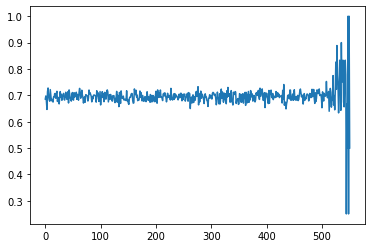

In [3]:
df_prob_mean = compute_prob_mean_lasse(df_post)
df_prob_mean.plot()

100%|████████████████████████████████████████████| 500/500 [00:08<00:00, 60.54it/s]


<AxesSubplot: >

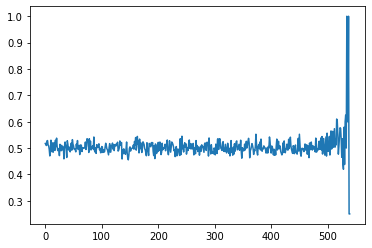

In [4]:
## In the plot above WE expect the probability of an award to be always 0.5 (because of how our df is created)
# The reason why you get 0.7 is because one has to first compute the average, then transform x--> 1/x
# (I just realised that now, and I am not even 100% why)
## You can just change your function as follows

    
def compute_prob_mean_lasse_new(df_post):
    df_prob=pd.DataFrame()

    # sample 500 awarded users
    for author in tqdm(df_post[df_post['awarded']!=0].author.sample(500).values):
        # compute the commutative sequence with "cumsum"
        sequence=df_post[df_post['author']==author].sort_values(by='created_utc').awarded.cumsum().values
        for k in range(0, max(sequence)):
            occur=np.count_nonzero(sequence == k)
            if k == 0:
                occur = occur + 1
            df_prob.loc[author,k] = (occur)   

    # compute mean
    df_prob_mean=df_prob.mean(axis=0, skipna=True).apply(lambda x:1/x)
    return df_prob_mean

df_post = create_random_df()
df_prob_mean = compute_prob_mean_lasse_new(df_post)
df_prob_mean.plot()

In [5]:
# now, it is important to make sure that each point in the plot above is an average across the same set of users
# You can achieve that by filtering only users with at least K awards, then limiting your x-axis from 0 to K

    
def compute_prob_mean_lasse_new(df_post, K ):
    
    awards_per_author = df_post.groupby("author")["awarded"].sum().reset_index()
    filtered_authors = awards_per_author[(awards_per_author["awarded"]>K)]["author"].values
    filtered_post = df_post[df_post["author"].isin(filtered_authors)].copy()

    
    df_prob=pd.DataFrame()

    # sample 500 awarded users
    for author in tqdm(filtered_post.author.sample(500).values):
        # compute the commutative sequence with "cumsum"
        sequence=df_post[df_post['author']==author].sort_values(by='created_utc').awarded.cumsum().values
        for k in range(0, K): ##NOTE SMALL CHANGE HERE
            occur=np.count_nonzero(sequence == k)
            if k == 0:
                occur = occur + 1
            df_prob.loc[author,k] = (occur)   
    # compute mean
    df_prob_mean=df_prob.mean(axis=0, skipna=True).apply(lambda x:1/x)
    return df_prob_mean
    


100%|███████████████████████████████████████████| 500/500 [00:03<00:00, 143.05it/s]


<AxesSubplot: >

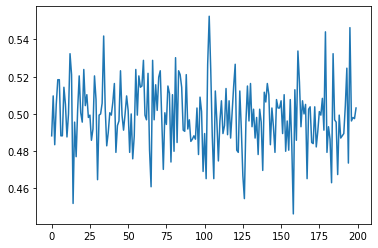

In [6]:
K = 200
df_post = create_random_df()
df_prob_mean = compute_prob_mean_lasse_new(df_post, K)
df_prob_mean.plot()

In [7]:
## THe code above is perfect. It can be just optimized slightly by using groupby to avoid for loops. see below

def compute_prob_mean_laura(df_post, K):
    
    ###FIRST I FILTER AUTHORS WITH AT LEAST K AWARDS
    awards_per_author = df_post.groupby("author")["awarded"].sum().reset_index()
    filtered_authors = awards_per_author[(awards_per_author["awarded"]>K)]["author"].values
    filtered_post = df_post[df_post["author"].isin(filtered_authors)].copy()


    #THEN COMPUTE THE CUMSUM
    filtered_post["cumsum"] = filtered_post.sort_values(by='created_utc').groupby("author")["awarded"].apply(pd.Series.cumsum)

    #THEN COMPUTE THE PROB
    df_prob = filtered_post.groupby(['author','cumsum'])["awarded"].count().reset_index()

    #THEN AVERAGE aND APPLY X--1/x
    df_prob_mean = df_prob[df_prob["cumsum"]<=K].groupby("cumsum")["awarded"].mean().apply(lambda x: 1/(x))
    return df_prob_mean


<AxesSubplot: xlabel='cumsum'>

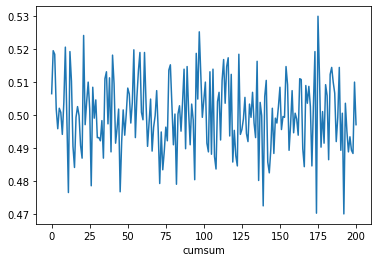

In [8]:
K = 200
df_post = create_random_df()
df_prob_mean = compute_prob_mean_laura(df_post, K)
df_prob_mean.plot()


In [9]:
## we can also add errorbars by repeating many times

K = 50
df_prob_means = [compute_prob_mean_laura(create_random_df(), K) for i in tqdm(range(100))]
df_prob_mean = pd.concat(df_prob_means,axis=1).agg(["mean","std","count"], axis=1)


100%|████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


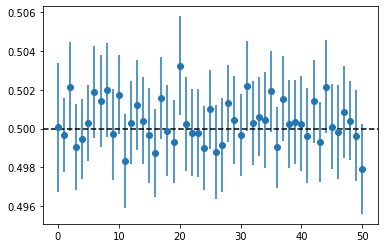

In [10]:
plt.errorbar(df_prob_mean.index, df_prob_mean["mean"], yerr=2*df_prob_mean["std"]/np.sqrt(df_prob_mean["count"]),ls="",marker="o")
plt.axhline(0.5,color='k',ls="--")

# One can see what happens with a "rich gets richer" model

In [11]:
def generate_new_post(sequence):
    ##Here the probability to receive an award depends linearly on the number of previous awards
    number_of_awards = sum(sequence)
    p = min(1, number_of_awards/100)
    return np.random.choice((0,1), p = [1-p, p])
    
def create_rich_gets_richer_user_data(n, len_sequence):
    ##THIS JUST CREATE A DATAFRAME for one user
    # n is the user_id
    # the awards are attributed accroding to a rich gets richer scheme    
    user_id = [n]*len_sequence
    awards = [1]
    for i in range(len_sequence):
        awards.append(generate_new_post(awards))
        
    times = range(len_sequence) #I assume that people post at every timestamp
    return pd.DataFrame(list(zip(user_id, awards, times)),columns = ["author","awarded","created_utc"])

    

def create_random_df(N_Users=1000, len_sequence=1000):
    ### JUST CREATE A  DF with many users
    list_ = [create_rich_gets_richer_user_data(n, len_sequence) for n in tqdm(range(0,N_Users))]
    df_post = pd.concat(list_)
    return df_post.reset_index(drop=True)


In [12]:
df_post = create_random_df()


100%|██████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.31it/s]


<AxesSubplot: xlabel='cumsum'>

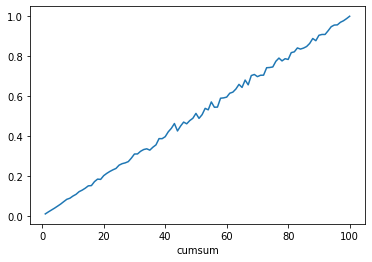

In [13]:
K = 100
df_prob_mean = compute_prob_mean_laura(df_post, K)
df_prob_mean.plot()
